In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit

In [2]:
path = Path.cwd()
datapath = path / 'spectroscopydata'
outputpath = path / 'spectroscopyresults'

# Global Scan & Calibration

In [18]:
data = pd.read_csv(datapath/'DigiLock-ScopeData.txt', sep="\t")
data_nr = pd.read_csv(datapath/'DigiLock-ScopeData_norepump.txt', sep = "\t")
timebase = 50 * 1e-3
divisions = 4
timeaxis = np.linspace(0,divisions*timebase,len(data_nr['Aux out [V]']))

Text(0.5, 1.0, 'Repump off')

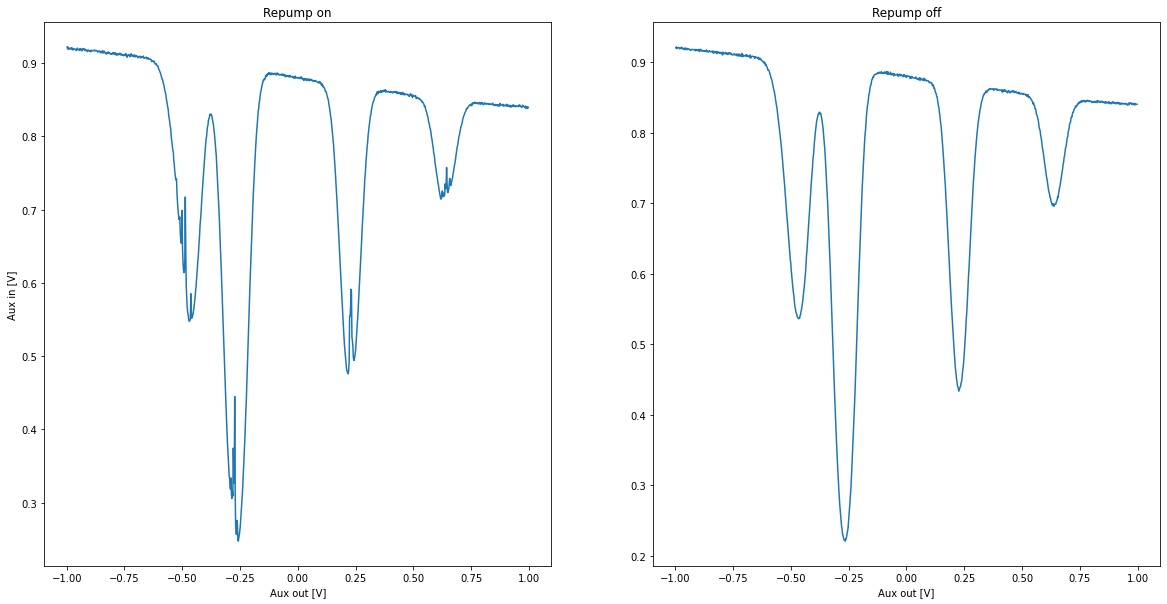

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data['Aux out [V]'],data['Aux in [V]'])
ax2.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],)
ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Repump on')
ax2.set_title('Repump off')

In [5]:
def gaussian(x,A,mean,var):
    return -A/np.sqrt(2*np.pi*var**2)*np.exp(-0.5*(x-mean)**2/var**2)

def global_gaussian(x,A1,A2,A3,A4,mean1,mean2,mean3,mean4,std1,std2,std3,std4,offset,slope):
    return gaussian(x,A1,mean1,std1)+gaussian(x,A2,mean2,std2)+gaussian(x,A3,mean3,std3)+gaussian(x,A4,mean4,std4)+offset+slope*x

In [10]:
popt, pcov = curve_fit(global_gaussian,data_nr['Aux out [V]'],data_nr['Aux in [V]'],bounds=([0,0,0,0,-0.7,-0.4,0.1,0.5,0,0,0,0,0,-0.2],[1,1,1,1,-0.3,0,0.4,0.75,0.5,0.5,0.5,0.5,1,0]))
perr = np.sqrt(np.diag(pcov))

In [11]:
perr

array([0.00017178, 0.00016551, 0.00015468, 0.00016618, 0.00019163,
       0.00010004, 0.00014674, 0.00041505, 0.00020247, 0.00010464,
       0.00015198, 0.00044095, 0.0002847 , 0.000428  ])

A1 = 0.04262 +/- 0.000172, mean1 = -0.47112 +/- 0.000192 ,std1 = 0.04656 +/- 0.000202
A1 = 0.07965 +/- 0.000166, mean1 = -0.26739 +/- 0.000100 ,std1 = 0.04583 +/- 0.000105
A1 = 0.04482 +/- 0.000155, mean1 = 0.22801 +/- 0.000147 ,std1 = 0.04066 +/- 0.000152
A1 = 0.01618 +/- 0.000166, mean1 = 0.63781 +/- 0.000415 ,std1 = 0.04124 +/- 0.000441
offset = 0.88000 +/- 0.000285, slope = -0.04186 +/- 0.000428


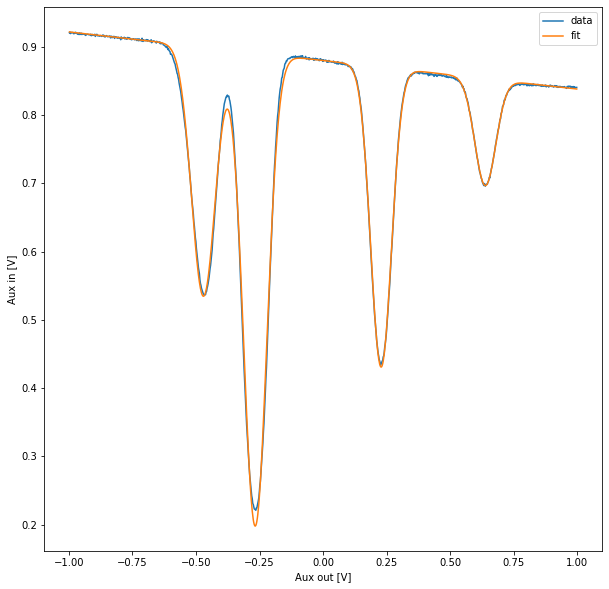

In [13]:
plt.figure(figsize = (10,10))
plt.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],label='data')
plt.plot(data_nr['Aux out [V]'], global_gaussian(data_nr['Aux out [V]'],*popt),label='fit')
#plt.plot(data_nr['Aux out [V]'],popt[-1]*data_nr['Aux out [V]']+popt[-2])
plt.xlabel('Aux out [V]')
plt.ylabel('Aux in [V]')
plt.legend()
np.sqrt(np.sum((global_gaussian(data_nr['Aux out [V]'],*popt)-data_nr['Aux in [V]'])**2))
for i in range(0,4):
    print("A1 = {:.5f} +/- {:5f}, mean1 = {:.5f} +/- {:5f} ,std1 = {:.5f} +/- {:5f}".format(popt[i],perr[i],popt[i+4],perr[i+4],popt[i+8],perr[i+8]))
print("offset = {:.5f} +/- {:5f}, slope = {:.5f} +/- {:5f}".format(popt[-2],perr[-2],popt[-1],perr[-1]))

In [35]:
print("Use 87Rb F=2 -> F' and 87Rb F=1 -> F' for calibration.")
delta_t = divisions*timebase/2 * (popt[7]-popt[4])
delta_t_err = divisions*timebase/2 * np.sqrt(perr[7]**2+perr[4]**2)
print("Time difference: ({:f} +/- {:f}) s".format(delta_t,delta_t_err))
print("Literaturwert: 6.834682 GHz")
K = 6.834682/delta_t
K_err = 6.834682/delta_t**2 * delta_t_err
print("Kalibrierungsfaktor K = ({:.3f} +/- {:.3f}) GHz/s".format(K,K_err))

Use 87Rb F=2 -> F' and 87Rb F=1 -> F' for calibration.
Time difference: (0.110893 +/- 0.000046) s
Literaturwert: 6.834682 GHz
Kalibrierungsfaktor K = (61.633 +/- 0.025) GHz/s


In [47]:
print("Frequenzabstand 85Rb F=3 -> F':")
dt = divisions*timebase/2 * (popt[5]-popt[4])
dt_err = divisions*timebase/2 * np.sqrt(perr[5]**2+perr[4]**2) 
f = K * dt
f_err = np.sqrt((dt*K_err)**2+(K*dt_err)**2)
print("Messung: ({:.4f} +/- {:.4f}) GHz".format(f,f_err))
print("Theorie: 1.298 GHz")
print("rel. Abweichung: {:.2f}%".format((f-1.298)/1.298*100))

Frequenzabstand 85Rb F=3 -> F':
Messung: (1.2557 +/- 0.0014) GHz
Theorie: 1.298 GHz
rel. Abweichung: -3.26%


In [49]:
print("Frequenzabstand 85Rb F=2 -> F':")
dt = divisions*timebase/2 * (popt[6]-popt[4])
dt_err = divisions*timebase/2 * np.sqrt(perr[6]**2+perr[4]**2) 
f = K * dt
f_err = np.sqrt((dt*K_err)**2+(K*dt_err)**2)
print("Messung: ({:.4f} +/- {:.4f}) GHz".format(f,f_err))
print("Theorie: 4.33 GHz")
print("rel. Abweichung: {:.2f}%".format((f-4.33)/4.33*100))

Frequenzabstand 85Rb F=2 -> F':
Messung: (4.3089 +/- 0.0023) GHz
Theorie: 4.33 GHz
rel. Abweichung: -0.49%
